### Autoencoders with keras example
#### Tutorial from https://blog.keras.io/building-autoencoders-in-keras.html


In [10]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
import numpy as np

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [84]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
print(x_train[:5])

(60000, 784)
(10000, 784)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [3]:
# Train the autoencoder for 50 epochs.
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
60000/60000 [==============================] - 2s 39us/sample - loss: 0.6953 - val_loss: 0.6952
Epoch 2/50
60000/60000 [==============================] - 2s 34us/sample - loss: 0.6951 - val_loss: 0.6950
Epoch 3/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.6949 - val_loss: 0.6948
Epoch 4/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.6947 - val_loss: 0.6946
Epoch 5/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.6946 - val_loss: 0.6944
Epoch 6/50
60000/60000 [==============================] - 2s 30us/sample - loss: 0.6944 - val_loss: 0.6942
Epoch 7/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6942 - val_loss: 0.6941
Epoch 8/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6940 - val_loss: 0.6939


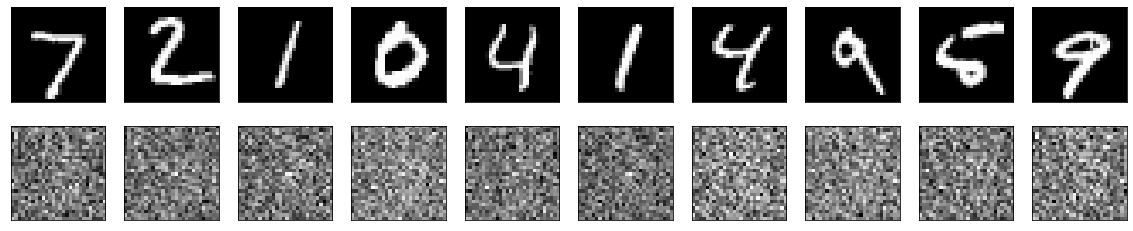

In [5]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
encoded_imgs.shape

(10000, 32)

____________________
### Based on Example from: https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

In [6]:
# Load MNIST data and normalize to values between 0 and 1

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [87]:
# Auxiliar functions:
# Loss function, gradient function, generic function to train models (to train different models and compare), and a function to plot some digits to compare original vs different models.

import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List

def loss(x: np.ndarray, x_bar: np.ndarray) -> float:
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model: Model, inputs: np.ndarray):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model: Model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    num_epochs = 10
    batch_size = 400

    for epoch in range(num_epochs):
        print("Epoch: ", epoch)
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))
        
def plot_predictions(models: List[Model]):
    predictions = []
    for m in models:
        predictions.append(np.array(m.predict(x_test)[0]))
    n = 10  # how many digits we will display
    rows = len(models) # how many rows to plot = number of models
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(rows+1, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for idx,p in enumerate(predictions):
            ax = plt.subplot(rows+1, n, i + 1 + (idx+1)*n)
            plt.imshow(p[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

In [55]:
# Define first Model
class FullyConnectedAutoEncoder(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        
        self.bottleneck = Dense(16, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [56]:
model = FullyConnectedAutoEncoder()
train_model(model)

Epoch:  0
Step: 0,Loss: 0.04842933639883995
Epoch:  1
Step: 1,Loss: 0.036887891590595245
Epoch:  2
Step: 2,Loss: 0.032858382910490036
Epoch:  3
Step: 3,Loss: 0.03114898130297661
Epoch:  4
Step: 4,Loss: 0.03045516088604927
Epoch:  5
Step: 5,Loss: 0.02992573007941246
Epoch:  6
Step: 6,Loss: 0.029436856508255005
Epoch:  7
Step: 7,Loss: 0.028962843120098114
Epoch:  8
Step: 8,Loss: 0.028589637950062752
Epoch:  9
Step: 9,Loss: 0.02816178649663925


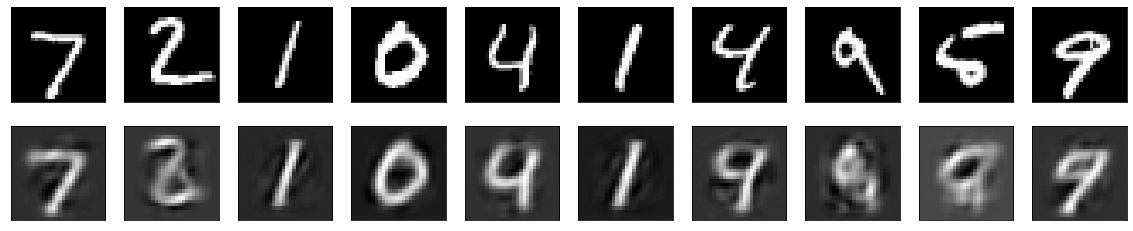

In [83]:
plot_predictions([model])

In [52]:
# Define second autoencoder with higher representation space.
class FullyConnectedAutoEncoder2(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder2, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(64, activation='relu')
        self.dense2 = Dense(32, activation='relu')
        
        self.bottleneck = Dense(32, activation='relu')
    
        self.dense4 = Dense(32, activation='relu')
        self.dense5 = Dense(64, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [53]:
# We train the new model
model2 = FullyConnectedAutoEncoder2()
train_model(model2)


Epoch:  0
Step: 0,Loss: 0.046129729598760605
Epoch:  1
Step: 1,Loss: 0.03458147495985031
Epoch:  2
Step: 2,Loss: 0.030395925045013428
Epoch:  3
Step: 3,Loss: 0.02902107872068882
Epoch:  4
Step: 4,Loss: 0.027673007920384407
Epoch:  5
Step: 5,Loss: 0.026386484503746033
Epoch:  6
Step: 6,Loss: 0.02555564045906067
Epoch:  7
Step: 7,Loss: 0.024936452507972717
Epoch:  8
Step: 8,Loss: 0.024322107434272766
Epoch:  9
Step: 9,Loss: 0.023759128525853157


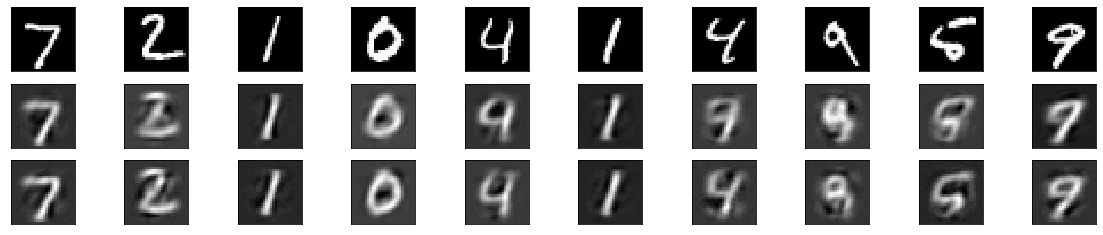

In [57]:
models = [model, model2]
plot_predictions(models)

In [59]:
# Define a third autoencoder with even higher representation space, to compare.
class FullyConnectedAutoEncoder3(Model):
    def __init__(self):
        super(FullyConnectedAutoEncoder3, self).__init__()
        self.flatten_layer = Flatten()
        self.dense1 = Dense(256, activation='relu')
        self.dense2 = Dense(128, activation='relu')
        
        self.bottleneck = Dense(128, activation='relu')
    
        self.dense4 = Dense(128, activation='relu')
        self.dense5 = Dense(256, activation='relu')
        
        self.dense_final = Dense(784)
        
    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped

In [60]:
# We train the new model
model3 = FullyConnectedAutoEncoder3()
train_model(model3)


Epoch:  0
Step: 0,Loss: 0.026408446952700615
Epoch:  1
Step: 1,Loss: 0.0191936232149601
Epoch:  2
Step: 2,Loss: 0.015645630657672882
Epoch:  3
Step: 3,Loss: 0.014702945947647095
Epoch:  4
Step: 4,Loss: 0.01359639223664999
Epoch:  5
Step: 5,Loss: 0.012326325289905071
Epoch:  6
Step: 6,Loss: 0.012035190127789974
Epoch:  7
Step: 7,Loss: 0.011520982719957829
Epoch:  8
Step: 8,Loss: 0.011186291463673115
Epoch:  9
Step: 9,Loss: 0.010904383845627308


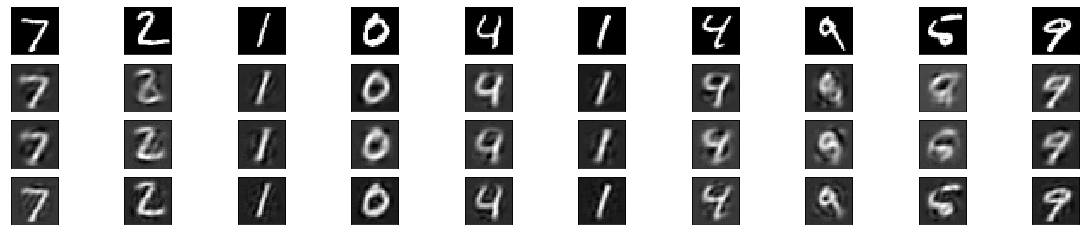

In [86]:
plot_predictions([model,model2,model3])

In [79]:
class ComposeAutoEncoder(Model):
    def __init__(self):
        super(ComposeAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
        # this is our input placeholder
        input_img = Input(shape=(28,28))

        self.flatten_input = Flatten()(input_img)
        # "Encoder layers"
        self.encoder1 = Dense(64, activation='relu')(self.flatten_input)
        self.encoder2 = Dense(32, activation='relu')(self.encoder1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = Dense(encoding_dim, activation='relu')(self.encoder2)
        # this model maps an input to its encoded representation
        self.encoder = Model(input_img, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded (32-dimensional) input
        self.encoded_input = Input(shape=(encoding_dim,))
        self.decoder1 = Dense(32, activation='relu')(self.encoded_input)
        self.decoder2 = Dense(64, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded_flatten = Dense(784, activation='sigmoid')(self.decoder1)
        self.decoded = Reshape((28,28))(self.decoded_flatten)
        # create the decoder model
        self.decoder = Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [80]:
# We train the new model
model4 = ComposeAutoEncoder()

In [81]:
train_model(model4)

Epoch:  0
Step: 0,Loss: [1.2205236e-04 8.4579056e-05 3.8783227e-03 1.4261925e-02 3.6485408e-02
 6.2108438e-02 7.5399920e-02 8.6613707e-02 9.1068394e-02 8.6307980e-02
 8.0713205e-02 7.6442480e-02 7.2688945e-02 7.2843887e-02 7.5637765e-02
 8.2045674e-02 8.5179679e-02 8.8441305e-02 8.7326452e-02 8.5379608e-02
 7.9280473e-02 7.9930775e-02 7.4073337e-02 6.2218029e-02 3.8940147e-02
 1.7031699e-02 6.7243562e-03 3.2698791e-04]
Epoch:  1
Step: 1,Loss: [4.1443714e-06 2.6766570e-06 3.7845497e-03 1.3897239e-02 2.9912598e-02
 4.4657633e-02 5.4312617e-02 6.8142921e-02 7.3771134e-02 7.1025610e-02
 6.4086869e-02 5.9047330e-02 5.6721050e-02 5.9964053e-02 6.5671891e-02
 7.1938425e-02 6.8608373e-02 6.6177644e-02 6.1072335e-02 5.8690678e-02
 5.9340749e-02 5.9817161e-02 5.3152867e-02 4.1521020e-02 2.8285397e-02
 1.6569614e-02 6.5992177e-03 2.2182478e-04]
Epoch:  2
Step: 2,Loss: [1.1142801e-06 5.6839571e-07 3.7820919e-03 1.2757913e-02 2.5640873e-02
 3.7220128e-02 4.4749539e-02 5.9256531e-02 6.3068062e-02 5.

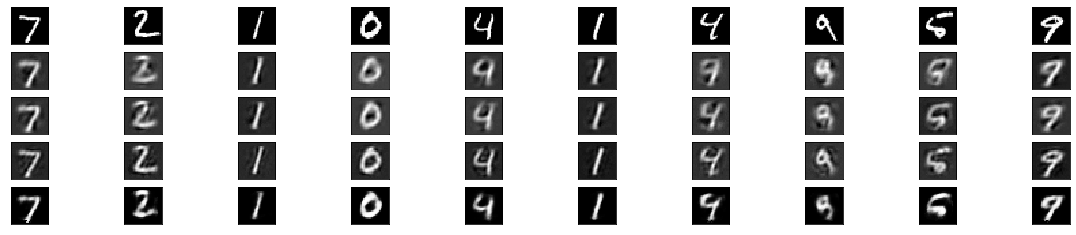

In [88]:
plot_predictions([model,model2,model3,model4])

In [48]:
model4.encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_59 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_60 (Dense)             (None, 32)                1056      
Total params: 53,376
Trainable params: 53,376
Non-trainable params: 0
_________________________________________________________________
